# Plot BlueSeis BSPF Events from Catalog

! Should be run in pygmt environment !

With pressure sensor parascientific and new sensor 

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

from andbro__savefig import __savefig
from obspy.clients.fdsn import Client

In [2]:
from functions.catalog_to_dataframe import __catalog_to_dataframe
from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [4]:
config = {}

date1 = "20221001"
date2 = "20230615"

## ______________________________________________
## small bounds
# config['minlatitude'], config['maxlatitude'] = 32, 35
# config['minlongitude'], config['maxlongitude'] = -118, -115
# config['eventfile'] = "BSPF_event_catalog"

## ______________________________________________
## normal bounds
config['minlatitude'], config['maxlatitude'] = 31, 35
config['minlongitude'], config['maxlongitude'] = -119, -114
config['eventfile'] = f"BSPF_catalog_{date1}_{date2}"

## ______________________________________________
## extended bounds
# config['minlatitude'], config['maxlatitude'] = 30, 37
# config['minlongitude'], config['maxlongitude'] = -120, -113
# config['eventfile'] = "BSPF_catalog_extended"


config['BSPF_lon'] = np.array([-116.455439])
config['BSPF_lat'] = np.array([33.610643])

# config['minmagnitude'] = 2.5

config['tbeg'] = obs.UTCDateTime(date1)
config['tend'] = obs.UTCDateTime(date2)

config['triggerfile'] = f"BSPF_catalog_{date1}_{date2}_triggered.pkl"

config['gcmt_file'] = f"gcmt_solutions_{date1}_{date2}.xml"

config['path_to_data'] = data_path+"BSPF/data/"

config['path_to_catalogs'] = data_path+"BSPF/data/catalogs/"

config['out_figures'] = data_path+"BSPF/figures/"

config['outpath'] = data_path+"BSPF/"

In [5]:
def __read_pickle(path, filename):

    import pickle

    with open(path+filename, 'rb') as f:
        triggerfile = pickle.load(f)

    return triggerfile

In [6]:
# def __find_matches(trigger_events, catalog):

#     trigger_times, cosum = [], []
#     for n, trig in enumerate(trigger_events.index):
#         trigger_times.append(trig['trigger_time'][n])
#         cosum.append(trig['coincidence_sum'])


#     matches, time_diffs, events_triggered, idxs = [], [], [], []

#     ## extract origin times from catalog
#     event_times = [catalog.events[j].origins[0].time for j in range(len(catalog))]


#     for trigger_time in trigger_times:

#         ## compute time differences in seconds
#         diff = [event_time-trigger_time for event_time in event_times]

#         ## only the ones before the trigger in time
#         abs_diff = [abs(d) for d in diff if d < 0]

#         ## get closest event
#         t_min, t_idx = min(abs_diff), diff.index(-min(abs_diff))

#         time_diffs.append(t_min)
#         matches.append(trigger_time)
#         events_triggered.append(event_times[t_idx])
#         idxs.append(t_idx)

#     cat_sel = [catalog.events[idx] for idx in idxs]


#     t_days = [(match-obs.UTCDateTime("2022-10-01"))/86400 for match in matches]
#     plt.figure(figsize=(15,5))
#     for tt, dd, cosum in zip(t_days, time_diffs, cosum):
#         if cosum == 4:
#             plt.scatter(tt, dd, zorder=2, color='red', s=13, alpha=0.7)
#         if cosum == 5:
#             plt.scatter(tt, dd, zorder=2, color='orange', s=13, alpha=0.7)
#         if cosum == 6:
#             plt.scatter(tt, dd, zorder=2, color='green', s=13, alpha=0.7)

#     plt.yscale("log")
#     plt.grid(which="both", zorder=-1, ls=":")
#     plt.ylabel("Time Differences (s)")
#     plt.xlabel("Time (days)")
#     plt.xlim(0, 190)
#     plt.title(f"LTA-STA Trigger: {len(events_triggered)}")

#     return np.array(matches), np.array(events_triggered), cat_sel

## Load Data

### load catalog with all events

In [9]:
cat_all = obs.read_events(config['path_to_catalogs']+config['eventfile']+"_all.xml")

events_all_df = __catalog_to_dataframe(cat_all)

events_all_df = __add_distances_and_backazimuth(config['BSPF_lat'], config['BSPF_lon'], events_all_df)

In [10]:
events_all_df = events_all_df.rename_axis('timestamp').reset_index()
events_all_df['seconds'] = [abs((events_all_df.timestamp.min()-tt).total_seconds()) for tt in events_all_df.timestamp]

### load triggered events

In [11]:
cat_select_df = __read_pickle(config['path_to_catalogs'], config['triggerfile'])

In [12]:
cat_select_df

,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km
0,2022-10-01 05:36:11.240,33.489667,-116.507167,9120.0,1.13,ml,20171.24,2022-10-01T05:36:10.344538Z,2022-10-01T05:36:15.817357Z,2022-10-01T05:36:11.240000Z,4.0,199.712618,14.252022
1,2022-10-01 21:26:43.530,33.978000,-116.730500,15130.0,2.08,ml,77203.53,2022-10-01T21:26:51.694538Z,2022-10-01T21:26:55.332495Z,2022-10-01T21:26:43.530000Z,6.0,328.065144,48.053535
2,2022-10-02 03:25:16.440,33.484333,-116.508500,8040.0,1.49,ml,98716.44,2022-10-02T03:25:19.269538Z,2022-10-02T03:25:20.870534Z,2022-10-02T03:25:16.440000Z,6.0,199.394033,14.850966
3,2022-10-02 15:51:37.180,33.480167,-116.398000,8240.0,1.68,ml,143497.18,2022-10-02T15:51:37.444539Z,2022-10-02T15:51:41.755700Z,2022-10-02T15:51:37.180000Z,6.0,159.749086,15.423592
4,2022-10-02 21:52:54.280,33.485333,-116.509333,9650.0,0.99,ml,165174.28,2022-10-02T21:52:57.394539Z,2022-10-02T21:52:59.070083Z,2022-10-02T21:52:54.280000Z,6.0,199.820062,14.772415
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,2023-06-05 17:22:59.900,33.992667,-116.609167,15140.0,0.91,ml,21403379.90,2023-06-05T17:23:13.670000Z,2023-06-05T17:23:11.132495Z,2023-06-05T17:22:59.900000Z,4.0,341.473421,44.700753
278,2023-06-05 17:23:05.920,33.992667,-116.612500,14750.0,1.95,ml,21403385.92,2023-06-05T17:23:13.670000Z,2023-06-05T17:23:17.079150Z,2023-06-05T17:23:05.920000Z,4.0,341.100143,44.800001
279,2023-06-07 06:03:42.030,33.965667,-116.946000,7240.0,2.58,ml,21535422.03,2023-06-07T06:03:52.040000Z,2023-06-07T06:03:54.073471Z,2023-06-07T06:03:42.030000Z,6.0,311.053330,60.123060
280,2023-06-11 02:38:25.290,33.604000,-116.628000,13450.0,1.12,ml,21868705.29,2023-06-11T02:38:28.860000Z,2023-06-11T02:38:31.166828Z,2023-06-11T02:38:25.290000Z,6.0,267.413578,16.031930


### load GCMT catalog

In [13]:
cat_gcmt = obs.read_events(config['path_to_catalogs']+config['gcmt_file'])

In [14]:
cat_gcmt_df = __catalog_to_dataframe(cat_gcmt)
cat_gcmt_df.magnitude.min(), cat_gcmt_df.shape

(5.1, (319, 5))

In [15]:
cat_gcmt_usgs = obs.read_events(config['path_to_catalogs']+"gmt_usgs_m3_m4.xml")
cat_gcmt_usgs = cat_gcmt_usgs.filter("magnitude >= 4.0", "time > 2022-12-31", "time < 2023-01-01")

### load shape file for faults

from USGS: https://usgs.maps.arcgis.com/apps/webappviewer/index.html?id=5a6038b3a1684561a9b0aadf88412fcf

In [16]:
faults = gpd.read_file(config['path_to_data']+"hazfaults2014/hazfaults2014.shp")

In [17]:
# x,y = faults.geometry[0].coords.xy
# print(np.array(x))
# plt.plot(x,y)

## Plot Triggered Catalog

### Plots

In [18]:
def __plot_timeline(catalog_df, catalog_all_df):

    fig, ax = plt.subplots(1, 1, figsize=(15,5))

    catalog_all_df.sort_values("magnitude")
    catalog_df.sort_values("magnitude")

    cm = plt.get_cmap('viridis', 5)
#     cm.set_under('gray')

    cax = ax.scatter(catalog_df.origin,
                     catalog_df.distances_km,
                     s=4**catalog_df.magnitude,
                     c=catalog_df.magnitude,
                     alpha=0.8,
                     cmap=cm,
                     marker='o',
                     facecolors='none',
                     edgecolors='k',
                     vmin=0,
                     vmax=5
                    )

    ax.scatter(catalog_all_df.timestamp, catalog_all_df.distances_km,
               s=4**catalog_all_df.magnitude,
               c='grey', alpha=0.5, zorder=-1)




    cbar = plt.colorbar(cax, ax=ax, cmap=cm, pad=0.01, aspect=15, drawedges=False)
    cbar.set_label(label='Magnitude', size=16, color="white", labelpad=-31)
#     cbar.set_clim(0.0, 5.0)
#     cbar.ax.set_ylim(0.0, 5.0)
#
    ax.set_ylim(bottom=0)
    ax.set_ylabel("Distance (km)", fontsize=14)

    ax.grid(ls=":", zorder=-1)

    ax.set_xlim(ax.get_xlim()[0]+5, ax.get_xlim()[1]-5)
#     ax.set_xlim(config['tbeg']-4*86400, config['tend']+4*86400)

    ax.set_title(f"triggered={len(catalog_df)} of {len(catalog_all_df)} events", fontsize=18)

#     ax.tick_params(axis="y", labelsize=15)
#     ax.tick_params(axis="x", labelsize=15)

    plt.show();
    return fig

In [19]:
events_all_df[events_all_df.magnitude > 4.1]

,timestamp,latitude,longitude,depth,magnitude,type,backazimuth,distances_km,seconds
1506,2023-04-30 07:58:19.380,33.203667,-115.585833,1890.0,4.26,mw,118.921940,92.633226,18258584.95
1530,2023-04-30 07:10:10.180,33.189333,-115.593333,1880.0,4.29,mw,119.988859,92.820385,18255695.75
1531,2023-04-30 07:09:34.500,33.200833,-115.590000,2040.0,4.33,mw,119.209818,92.450188,18255660.07
2577,2023-04-01 01:16:07.810,33.381667,-116.909667,12960.0,4.15,mw,239.091314,49.261011,15728853.38
4475,2023-01-25 10:00:54.680,33.885000,-118.704500,14710.0,4.19,mw,278.931825,210.596640,10057940.25
5110,2022-12-31 12:12:26.650,33.397500,-116.393333,3880.0,4.14,mw,166.264929,24.334570,7905832.22


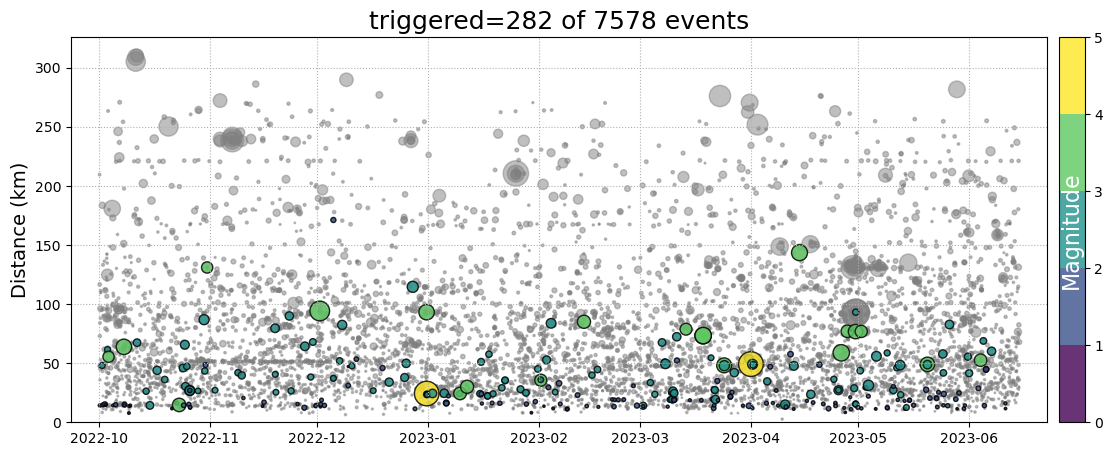

In [20]:
fig = __plot_timeline(cat_select_df, events_all_df)

fig.savefig(config['out_figures']+"timeline_triggered_extended.png")

In [21]:
__savefig(fig, config['out_figures'], "BSPF_timeline_trigger", mode="png", dpi=200)


   -> saving /home/andbro/kilauea-data/BSPF/figures/BSPF_timeline_trigger.png ...

   -> Done



### Map Plot

In [46]:
def __makeplot_eventmap(config, data1, data2):

    import pygmt
    import pandas as pd
    from obspy.imaging.beachball import beach

    def __plot_focal_mechanism(catalog):

        for ii in range(len(cat_gcmt_usgs)):

            try:
                strike = catalog.events[ii].focal_mechanisms[0].nodal_planes.nodal_plane_1.strike
                rake = catalog.events[ii].focal_mechanisms[0].nodal_planes.nodal_plane_1.rake
                dip = catalog.events[ii].focal_mechanisms[0].nodal_planes.nodal_plane_1.dip
                mag = catalog.events[ii].magnitudes[0].mag

                lat = catalog.events[ii].origins[0].latitude
                lon = catalog.events[ii].origins[0].longitude
                dep = catalog.events[ii].origins[0].depth

                focal_mechanism = dict(strike=strike, dip=dip, rake=rake, magnitude=mag)

                fig.meca(
                    spec=focal_mechanism,
                    scale="0.8c",
                    longitude=lon,
                    latitude=lat,
                    depth=dep,
                )

            except:
                print(f" -> failed for event {ii}")


    # Set the region
    region = [config['minlongitude'], config['maxlongitude'], config['minlatitude'], config['maxlatitude']]

    resolution = "30s"

    fig = pygmt.Figure()

#     fig.basemap(region=region, projection="M15c", frame=True)


    # make color pallets
    cmap = pygmt.makecpt(cmap='etopo1', series='-8000/5000/1000', continuous=True)
    # cmap = pygmt.makecpt(cmap='etopo1', continuous=True)

    ## define etopo data file
    topo_data = pygmt.datasets.load_earth_relief(resolution=resolution, region=region)

    ## adjust land and sea/lakes
    land = topo_data * pygmt.grdlandmask(region=region,
                                         spacing=resolution,
                                         maskvalues=[0, 1],
                                         resolution="f"
                                        )
    wet = topo_data * pygmt.grdlandmask(region=region,
                                        spacing=resolution,
                                        maskvalues=[1, "NaN"],
                                        resolution="f"
                                       )

    ##plot high res topography
    fig.grdimage(
        grid=topo_data,
        region=region,
        projection='M5i',
        shading=True,
        cmap = cmap,
        frame=True,
        nan_transparent=True
    )


    cmap_wet = pygmt.makecpt(cmap='etopo1', series='-7999/5000/1000', continuous=True)

    fig.grdimage(
        grid=wet,
        region=region,
        projection='M5i',
        shading=True,
        cmap=cmap_wet,
        frame=True,
        nan_transparent=True,
    )


    cmap = pygmt.makecpt(cmap='etopo1', series='-8000/5000/1000', continuous=True)
    fig.colorbar(cmap=cmap, position="g-118.8/32.45+w3c/0.3c+h", box="+gwhite+c0.1+r",
                 frame=["x+lElevation", r"y+l(km)"], scale=0.001, transparency=20)


    ## add coastlines
    fig.coast(shorelines=True, borders="1/0.4p,black,solid", frame=False)

    ## add map scale
    fig.basemap(map_scale="jBL+c32+f+w50k+u+o10.9/.6",frame=False)

    ## add north rose
#     fig.basemap(rose='jTR+o0.1c+w1c',frame=False)

    ## add fault lines
    for n in range(faults.shape[0]):
        try:
            xx, yy = faults.geometry[n].coords.xy
            fig.plot(x=xx,y=yy,pen="1p,red")
        except:
            print(n)

    ## colorbar colormap
#     cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.magnitude.min(), data1.magnitude.max()])
#     cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.timestamp.astype(str)[0], data1.timestamp.astype(str)[len(data1)-1]])
#     cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.seconds.min(), data1.seconds.max()])
    cmap_depth = pygmt.makecpt(cmap="viridis", series=[data1.depth.min()/1000, data1.depth.max()/1000])

#     ## plot data coordinates
    fig.plot(
        x=data2.longitude,
        y=data2.latitude,
        size=0.04*2**data2.magnitude,
        fill='grey',
        style="cc",
        pen="0p,black",
    )

    fig.plot(
        x=data1.longitude,
        y=data1.latitude,
        size=0.04*2**data1.magnitude,
        fill=data1.depth/1000,
#         fill=data1.seconds,
        cmap=True,
        style="cc",
        pen="0.1p,black",
        transparency=50,
    )

    ## plot PFO
    fig.plot(
        x=config['BSPF_lon'],
        y=config['BSPF_lat'],
        size=np.array([0.3]),
        fill="red",
        style="t0.5c",
        pen="black",
    )

    fig.text(
        text="PFO",
        x=config['BSPF_lon'],
        y=config['BSPF_lat'],
        offset=[0.35],
        font="9p,Helvetica-Bold,black"
    )

    ## add beachball
    __plot_focal_mechanism(cat_gcmt_usgs)

#     fig.plot(
#         x=config['BSPF_lon'],
#         y=config['BSPF_lat'],
#         size=10,
#         style="cc",
#         pen="0.1p,red",
#         transparency=100,
#     )

    ## add depth colorbar
#     fig.colorbar(frame='af+l"Depth (km)"', cmap=cmap_depth)
#     fig.colorbar(frame='af+l"Days"', transparency=20, cmap=cmap_mag,
#                  position="JMR+o-2.2c/3.1c+w5c/0.5c+n+mc", scale=1/86400,
#                  box="+gwhite+c0.1+r")
    fig.colorbar(frame='af+l"Depth (km)"', transparency=20, cmap=cmap_depth,
                 position="JMR+o-2.2c/3.1c+w5c/0.5c+n+mc",
                 box="+gwhite+c0.1+r")

    ## ________________________________________________
    ## overview plot

    region2 = [-122, -50, 20, 55]

    with fig.inset(position="jBL+o0.5c/0.2c", box="+pblack", region=region2, projection="M4c"):
        # Use a plotting method to create a figure inside the inset.
        fig.coast(
            land="gray",
            borders=[1, 2],
            shorelines="1/thin",
            water="white",
            # Use dcw to selectively highlight an area
#             dcw="US+gred",
        )
        fig.plot(
            x=config['BSPF_lon'],
            y=config['BSPF_lat'],
            size=np.array([0.3]),
            fill="red",
            style="t0.3c",
            pen="black",
        )

    ## save figure to file
    fig.savefig(config['outpath']+'tmp_event_map.png')

    fig.show();
    return fig

394


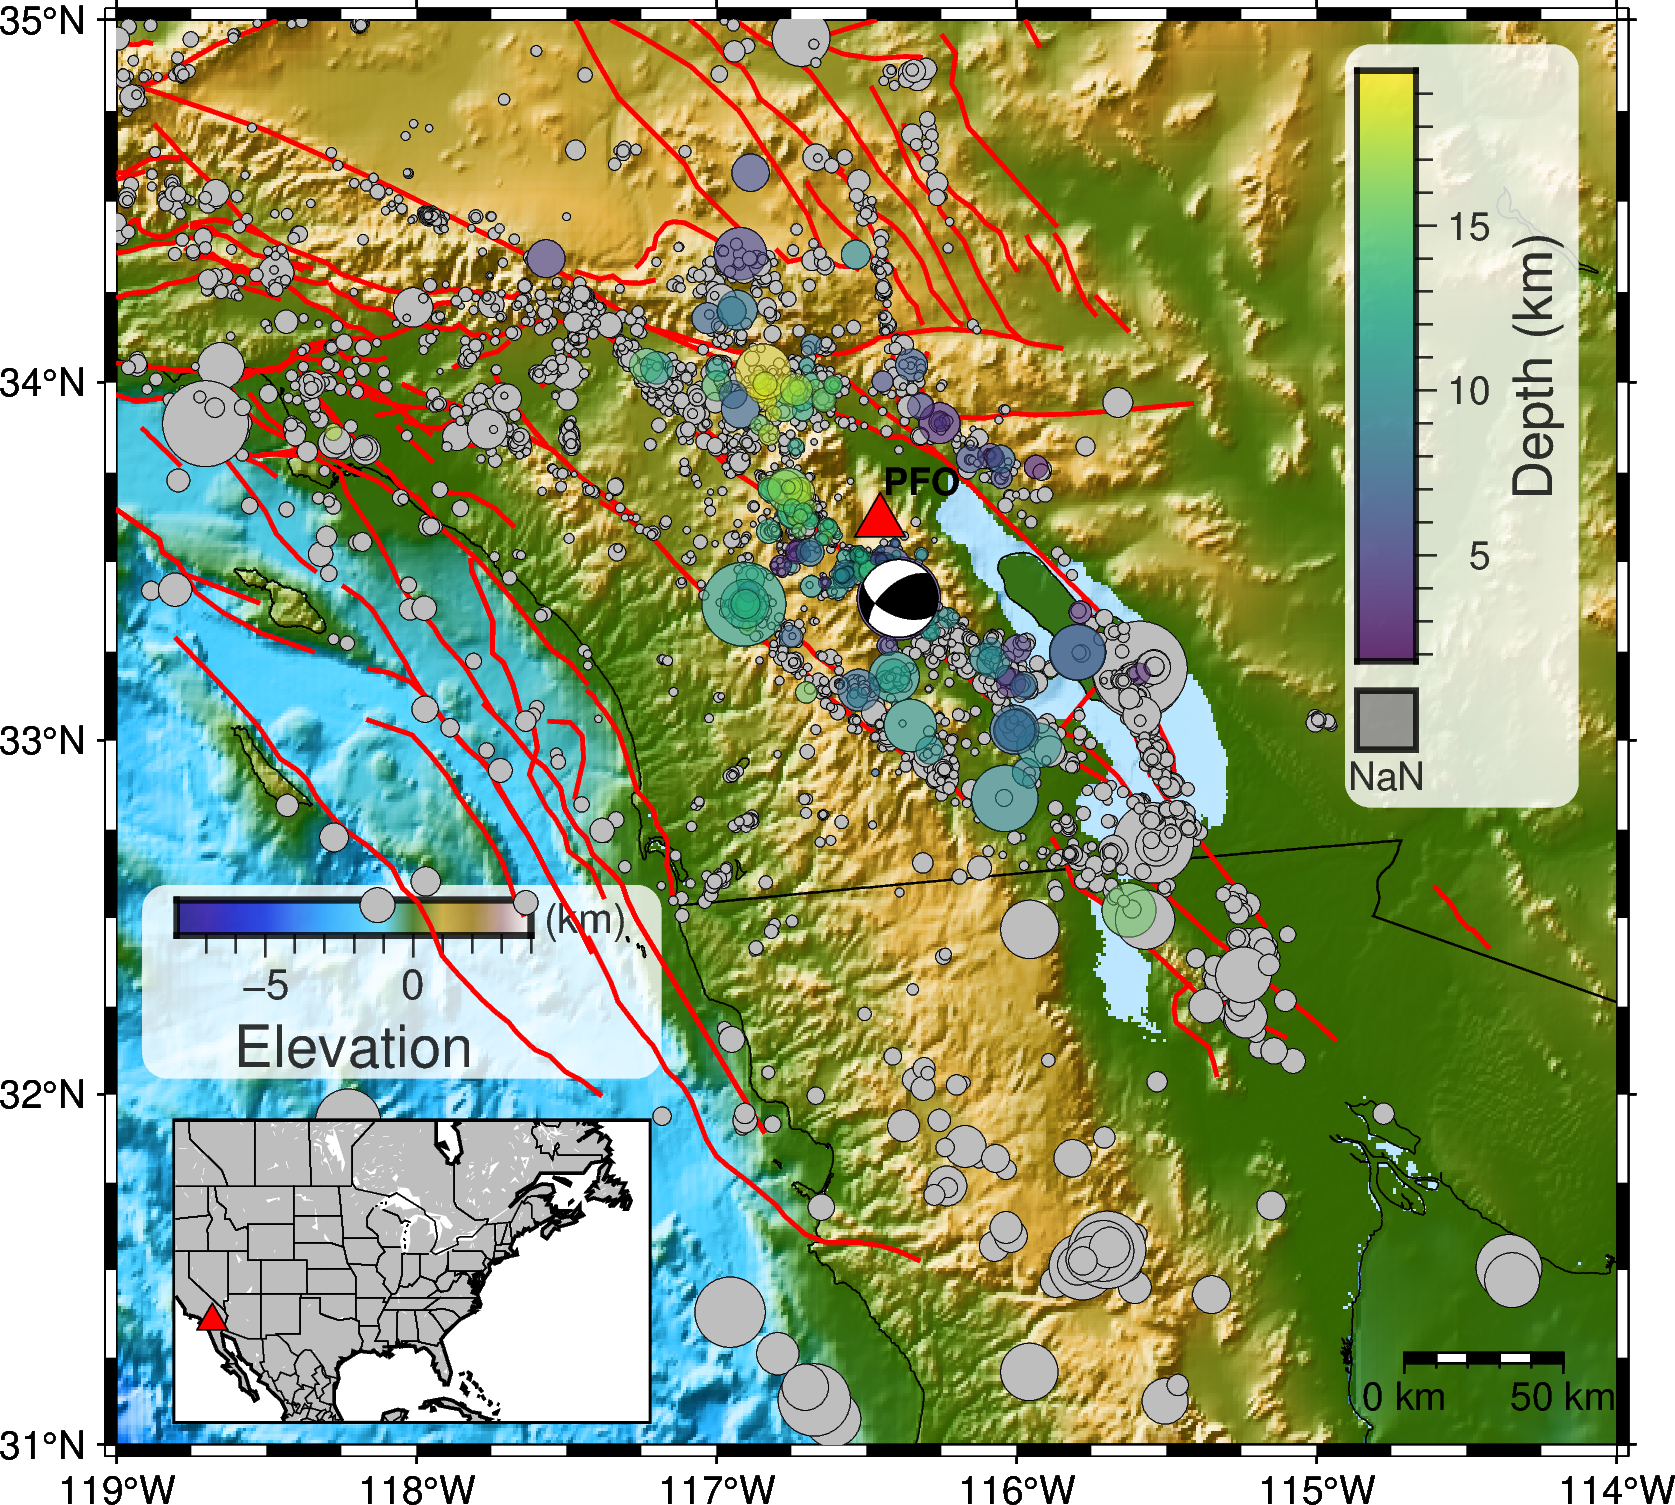

In [47]:
fig = __makeplot_eventmap(config, cat_select_df, events_all_df)

In [45]:
fig.savefig(config['out_figures']+"map_triggered.png")

### Centered Plot

In [25]:
# client = Client("ISC")

# ## events - all in area and time period
# events_all = client.get_events(minlatitude=config['minlatitude'], maxlatitude=config['maxlatitude'],
#                                minlongitude=config['minlongitude'], maxlongitude=config['maxlongitude'],
#                                starttime=config['tbeg'],
#                                endtime=config['tend'],
#                                )

In [26]:
# origin = event.preferred_origin() or event.origins[0]
# focmec = event.preferred_focal_mechanism() or event.focal_mechanisms[0]
# tensor = focmec.moment_tensor.tensor
# moment_list = [tensor.m_rr, tensor.m_tt, tensor.m_pp,
#                tensor.m_rt, tensor.m_rp, tensor.m_tp]

In [48]:
def __makeplot_polarmap(config, data1, data2):

    import pygmt

    reg = [config['minlongitude'], config['maxlongitude'], config['minlatitude'], config['maxlatitude']]

    scale = "8c"

    proj = f"E{config['BSPF_lon'][0]}/{config['BSPF_lat'][0]}/1/{scale}"

    resolution = "30s"

    ## __________________________________________

    fig = pygmt.Figure()

    fig.coast(projection=proj, region=reg, land="gray")


    fig.basemap(
        region=[0, 360, 0, 10],
        projection=f"P{scale}+a",
        frame=["xa45f", "+t"],
    )


    # make color pallets
    cmap = pygmt.makecpt(cmap='etopo1', series='-7999/5000/1000', continuous=True)

    ## define etopo data file
    topo_data = pygmt.datasets.load_earth_relief(resolution=resolution, region=reg)



    ##plot high res topography
    fig.grdimage(
        grid=topo_data,
        region=reg,
        projection=proj,
        shading=True,
        cmap = cmap,
        frame=True,
        nan_transparent=True
    )

    wet = topo_data * pygmt.grdlandmask(region=reg,  spacing=resolution, maskvalues=[1, "NaN"], resolution="f")

    fig.grdimage(
        grid=wet,
        region=reg,
        projection=proj,
        shading=True,
        cmap='seafloor',
        frame=True,
        nan_transparent=True
    )

    fig.coast(shorelines=True, borders="1/0.4p,black,solid", frame=False)

    ## colorbar colormap
    cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.magnitude.min(), data1.magnitude.max()])
    #     cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.timestamp.astype(str)[0], data1.timestamp.astype(str)[len(data1)-1]])
    cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.seconds.min(), data1.seconds.max()])

    ## add fault lines
    for n in range(faults.shape[0]):
        try:
            xx, yy = faults.geometry[n].coords.xy
            fig.plot(x=xx,y=yy,pen="1p,red")
        except:
            print(n)

    ## plot data coordinates
    fig.plot(
        x=data2.longitude,
        y=data2.latitude,
        size=0.04*2**data2.magnitude,
        fill='grey',
        style="cc",
        pen="0p,black",
    )

    fig.plot(
        x=data1.longitude,
        y=data1.latitude,
        size=0.04
        *2**data1.magnitude,
        fill=data1.seconds,
        cmap=True,
        style="cc",
        pen="0.8p,black",
        transparency=50,
    )

    ## plot PFO
    fig.plot(
        region=reg, projection=proj,
        x=config['BSPF_lon'],
        y=config['BSPF_lat'],
        size=np.array([0.3]),
        fill="red",
        style="t0.5c",
        pen="black",
    )

    fig.text(
        region=reg, projection=proj,
        text="PFO",
        x=config['BSPF_lon'],
        y=config['BSPF_lat'],
        offset=[0.35],
        font="9p,Helvetica-Bold,black"
    )

#     for n in range(faults.shape[0]):
#         try:
#             xx, yy = faults.geometry[n].coords.xy
#             fig.plot(x=xx,y=yy,pen="1p,red")
#         except:
#             print(n)

    fig.show()
    return fig

coast [WARNING]: Fill/clip continent option (-G) may not work for this projection.
coast [WARNING]: If the antipode (0/4.68337e-310) is in the ocean then chances are good it will work.
coast [WARNING]: Otherwise, avoid projection center coordinates that are exact multiples of 63.5446 degrees.


394


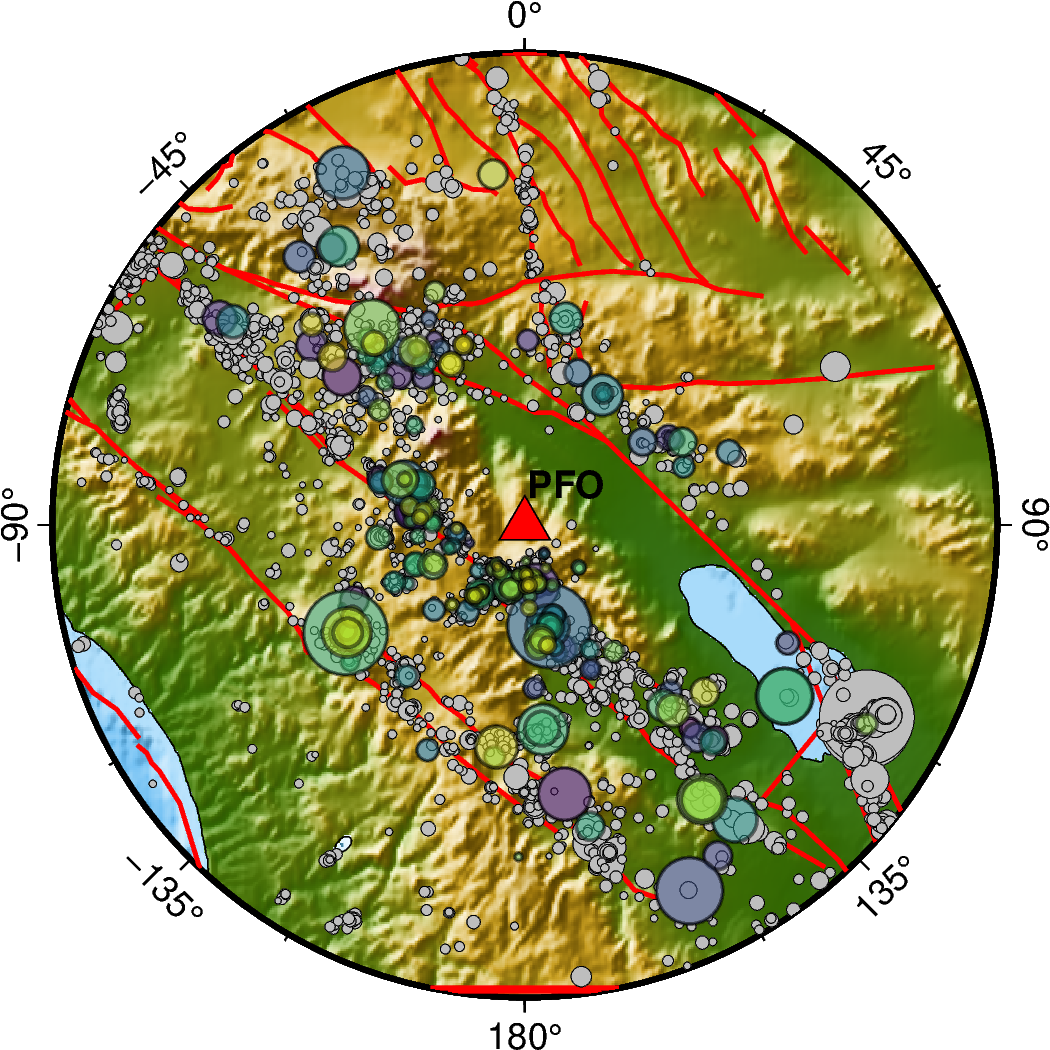

In [49]:
fig = __makeplot_polarmap(config, cat_select_df, events_all_df)

In [50]:
fig.savefig(config['out_figures']+f'BSPF_polarmap.png', dpi=200)

FileNotFoundError: No such directory: '/home/andbro/kilauea-data/BSPF/figures', please create it first.

## Plot Histogram

In [30]:
def __makeplot_histogram(catalog_all_df, catalog_df):

    from sklearn.linear_model import LinearRegression
    from numpy import log10, array, linspace


    catalog_all_df = catalog_all_df.sort_values("magnitude", ascending=False)
    catalog_df = catalog_df.sort_values("magnitude")

    ## bins=11, range=[-0.75,4.75]
#     hh_cum, bins_cum, _ = plt.hist(catalog_all_df.magnitude, bins=11, range=[-0.75,4.75], rwidth=0.9, color='#3776ab', cumulative=True)
#     plt.close()
#     bins_cum = [bins_cum[jj] + (abs(bins_cum[jj+1]-bins_cum[jj])/2) for jj in range(len(bins_cum)-1)]

    ## compute bins catalog all
    nn, bins = [], []
    for i in range(-1, 7, 1):
        nn.append(len(catalog_all_df[catalog_all_df.magnitude >= i]))
        bins.append(i+0.5)

    print(len(catalog_df), len(catalog_df[catalog_df.magnitude >= 4]))
    ## compute bins catalog triggered
    nn2, bins2 = [], []
    for i in range(-1, 7, 1):
        nn2.append(len(catalog_df[catalog_df.magnitude >= i]))
        bins2.append(i+0.5)


    x, y = array(bins)[2:-1], log10(nn[2:-1])

    ## ________________________________

    fig, ax = plt.subplots(1, 1, figsize=(5,5))

    ## plot histograms catalog all
    ax.bar(array(bins), nn, width=0.75, color='lightblue', zorder=2, alpha=0.8)
    ax.bar(x, 10**y, width=0.75, zorder=2)

    ## plot histograms catalog triggered
    ax.bar(array(bins2), nn2, width=0.5, color='darkorange', zorder=2, alpha=0.5)
#     ax.bar(x2, 10**y2, width=0.75, zorder=2)


    ## linear regression
    model = LinearRegression().fit(x.reshape((-1, 1)), y)
    r_sq = model.score(x.reshape((-1, 1)), y)
    x_axis = linspace(min(bins), max(bins), 50)
    reg1 = model.intercept_ + model.coef_ * x_axis

    ax.plot(x_axis, 10**reg1, color="k", ls="--", label=f"f(x)={round(model.coef_[0],2)}x+{round(model.intercept_,1)}")

    ## linear regression
    x2, y2 = x[:-1], y[:-1]
    model = LinearRegression().fit(x2.reshape((-1, 1)), y2)
    r_sq = model.score(x2.reshape((-1, 1)), y2)
    x_axis = linspace(min(bins), max(bins), 50)
    reg2 = model.intercept_ + model.coef_ * x_axis

#     ax.plot(x_axis, 10**reg2, color="k", ls=":", label=f"f(x)={round(model.coef_[0],2)}x+{round(model.intercept_,1)}")


    ax.text(3.5, 9e3, f"Total N = {len(catalog_all_df)}", fontsize=13)

    days = str(events_all_df.index.max()-events_all_df.index.min()).split(" ")[0]
    ax.text(3.5, 4e3, f"Days = {days}", fontsize=13)

    ax.grid(zorder=-1, ls=":", alpha=0.7, which="both")

    ax.legend(loc="upper right", fontsize=12)

    ax.set_yscale("log")

    ax.set_xlabel("Magnitude", fontsize=18)
    ax.set_ylabel("Number of Events", fontsize=18)

    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=11)

    ax.set_xticks(array(bins)-0.5)

    ax.set_title(f"Gutenberg-Richter Relation", fontsize=18)

    ax.tick_params(axis="y", labelsize=15)
    ax.tick_params(axis="x", labelsize=15)

    ax.set_ylim(0.2e0, 1e5)
    plt.show();
    return fig

In [31]:
fig = __makeplot_histogram(events_all_df, cat_select_df)

fig.savefig("catalog_all_histo.png")

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
import pygmt

fig = pygmt.Figure()

region = [config['minlongitude'], config['maxlongitude'], config['minlatitude'], config['maxlatitude']]


fig.basemap(region=region, projection="M15c", frame=True)

for ii in range(len(cat_gcmt_usgs)):

    try:
        strike = cat_gcmt_usgs.events[ii].focal_mechanisms[0].nodal_planes.nodal_plane_1.strike
        rake = cat_gcmt_usgs.events[ii].focal_mechanisms[0].nodal_planes.nodal_plane_1.rake
        dip = cat_gcmt_usgs.events[ii].focal_mechanisms[0].nodal_planes.nodal_plane_1.dip
        mag = cat_gcmt_usgs.events[ii].magnitudes[0].mag

        lat = cat_gcmt_usgs.events[ii].origins[0].latitude
        lon = cat_gcmt_usgs.events[ii].origins[0].longitude
        dep = cat_gcmt_usgs.events[ii].origins[0].depth

        focal_mechanism = dict(strike=strike, dip=dip, rake=rake, magnitude=mag)

        fig.meca(
            spec=focal_mechanism,
            scale="1c",
            longitude=lon,
            latitude=lat,
            depth=dep,
        )

    except:
        print(f" -> failed for event {ii}")


fig.show()

In [ ]:
from obspy.imaging.beachball import beachball


mt = [0.91, -0.89, -0.02, 1.78, -1.55, 0.47]
beachball(mt, size=2, linewidth=2, facecolor='k')

In [ ]:
for i in range(len(cat_gcmt_usgs)):
    print(type(cat_gcmt_usgs.events[i].focal_mechanisms[0].moment_tensor))
    try:
        print(cat_gcmt_usgs.events[i].focal_mechanisms[0].nodal_planes.nodal_plane_1.strike)
    except:
        print(i)

In [ ]:
print(cat_gcmt_usgs.events[0].focal_mechanisms[0].nodal_planes.nodal_plane_1.rake)
print(cat_gcmt_usgs.events[0].magnitudes[0].mag)